### About

**NOTE: This notebook is a continuation of my previous notebook which contained EDA.**   

You can refer the following links:  
- Part-1 EDA, feature engineering, and feature selection: https://www.kaggle.com/code/ayushsharma0812/part-1-eda-feature-engg-and-feature-selection 
- End-to-End implementation with deployment on AWS: https://github.com/Sharma-Ayush/Credit-Card-Fraud-Detection.git

### Objective of this notebook

The objective for this notebook is:  
- Feature Engineering.  
- Handling Imbalance.  
- Effect of feature engineering, imbalance handling techniques, and feature selection on model performance.  
- Pipelines for end-to-end deployment.  
- **How the performance of decision tree improved by 24.45%?**. 
- Feature importance, precision-recall curve and tree graphs.  
- Cross-validation and hyper parameter tuning of classification models.  
- Testing on test set.  

<u>PS:</u>  
- Feel free to contact me if you have any doubts or feedback through the comment section or my socials.
- Please upvote the notebook if you like it, as it would motivate me to develop more projects like these.

### My Socials

Follow me on these platforms, for more such content:  

LinkedIn: https://www.linkedin.com/in/ayush-sharma-660831125/  
Github: https://github.com/Sharma-Ayush  
Kaggle: https://www.kaggle.com/ayushsharma0812

### Import Required Libraries

In [95]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from imblearn.over_sampling import ADASYN, SMOTE

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics._scorer import make_scorer

from sklearn import tree
from graphviz import Source
from IPython.display import Image, display
import pydotplus

# extra modules
from warnings import filterwarnings
filterwarnings("ignore")


### Custom classes & functions

In [2]:
def double_log_transform(x):
    '''Transform x by taking the log of the data after shifting by 1. This operation is done two times iteratively.'''
    return np.log10(np.log10(x + 1) + 1)

def cube_root_transform(x):
    '''Transform x by taking the cube root of the data.'''
    return np.cbrt(x)

In [3]:
def area_under_precision_recall_curve(y_true, y_pred):
    '''Function that can compute the area under precision recall curve'''
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall

In [4]:
def find_best_cv_params(X, Y, training_pipeline, params, scoring, score_name, n_iter = 25, search_type = 'random', cv = 5):
    '''Perform random search or grid search on given X and Y using given model & parameter distributions preceeded by column_trasnformer, standard_scaler & resampler.
    n_iter(for random search), cv(no. of splits), scoring(score for finding best params) can be passed as parameters.'''
    
    if search_type == 'random':
        cross_validator = RandomizedSearchCV(training_pipeline,
                                             param_distributions = params,
                                             n_iter = n_iter,
                                             cv = cv,
                                             scoring = scoring,
                                             return_train_score = True,
                                             refit = False,
                                             error_score = 0,
                                             n_jobs = -1,
                                             random_state = 42)
    elif search_type == 'grid':
        cross_validator = GridSearchCV(training_pipeline,
                                       param_grid = params,
                                       scoring = scoring,
                                       cv = cv,
                                       n_jobs = -1,
                                       refit = False,
                                       error_score = 0,
                                       return_train_score = True)
    else:
        print('Invalid search type. Aborting.')
        return None

    cross_validator.fit(X, Y)
    print(f'For model - {training_pipeline.steps[-1][0]} {search_type} search:')
    print('----------------------------------------------------------')
    print(f'Best mean {score_name}:')
    print(f'Train set: {np.round(max(cross_validator.cv_results_['mean_train_score']), 3)}')
    print(f'Validation set: {np.round(cross_validator.best_score_, 3)}')
    print('----------------------------------------------------------')

    if search_type == 'random':
        return cross_validator.best_params_
    elif search_type == 'grid':
        print(cross_validator.best_params_)
        return cross_validator.best_params_

In [5]:
def train_and_evaluate_models(models, X_train, Y_train, X_test, Y_test):
    '''Train final model pipelines on train set and evaluate on test set. Print out the train and test scores and in the end return the best model pipeline.'''
    best_score = -1

    print('Final model training and evaluation:')
    print('----------------------------------------------------------')
    for index, model in enumerate(models):
        X_train_transformed = model['pre-processor'].fit_transform(X_train, Y_train)
        X_train_transformed, Y_train_transformed = model['resampler'].fit_resample(X_train_transformed, Y_train)
        model['model'].set_params(**model['best_params'])
        model['model'].fit(X_train_transformed, Y_train_transformed)

        Y_pred_train = model['model'].predict_proba(model['pre-processor'].transform(X_train))
        Y_pred_test = model['model'].predict_proba(model['pre-processor'].transform(X_test))

        train_score = area_under_precision_recall_curve(Y_train, Y_pred_train[:, 1])
        test_score = area_under_precision_recall_curve(Y_test, Y_pred_test[:, 1])

        print(f'For model - {model['name'].replace("_", " ")}:')
        print('----------------------------------------------------------')
        print(f'Area under precision-recall curve:')
        print(f'Train set: {np.round(train_score, 3)}')
        print(f'Test set: {np.round(test_score, 3)}')
        print('----------------------------------------------------------')

        if test_score > best_score:
            best_model_index = index
            best_score = test_score

    return models[best_model_index]['pre-processor'], models[best_model_index]['model']

In [67]:
def plot_decision_tree(model, target_classes):
    '''Plot decision tree graph from model'''
    tree_dot = tree.export_graphviz(model, out_file = None, class_names = target_classes, rounded = True, filled = True, )
    display(Image(pydotplus.graph_from_dot_data(tree_dot).create_png()))

### Loading the dataset

In [6]:
df_train = pd.read_csv('Data/creditcard_train.csv')

### Handling imbalance

We have already seen the huge imbalance that exists within our dataset. We need to mitigate that imbalance, otherwise our model will focus more on the majority class(genuine transactions). There are many techniques that we can use:  

1. <u>Undersampling of majority class:</u> We take random sample of majority class so that the size matches that of minority class. This will reduce the dataset size which is good if we want reduced computation effort and thus, will lead to faster computation but at the same time it will lead to loss of information and can give overly optimistic performance which we might not observe on test set.  

2. <u>Oversampling of minority class:</u> We do random sampling on minority class with replacement so that the size of minority class matches that of majority class. This will increase dataset's size which will lead to more computational effort but will preserve information unlike undersampling. Duplicates are generated within minority class and this can lead to overfitting.  

3. <u>Synthetic data generation techniques:</u> We use techniques like SMOTE, its variants or ADASYN to oversample minority class in a systematic way by adding points in between existing minority class data points with some logic behind it. This is the best way to upsample as duplication is not present but points are added along straight lines in between existing data points and this can lead to addition of artificial patterns. 

4. <u>Weight based sensitivity:</u> Many algorithms allow us to specify weights for each record of our dataset, we can assign higher weights to minority class records and the algorithm will focus more on them.

I would like to try both synthetic generation and weight based sensitivity, then compare them but the dataset is decently big in size and I want to perform cross-validaiton for hyper parameter tuning as well and thus, there is a problem here.  

When we generate cross-validation sets they should be first split up and then each of the set should be passed through the synthetic generator, any other transformations and then finally evaluated upon. This is done after splitting so that the information doesn't leak in between train and validation sets.

I will use ADASYN for synthetic generation of new data points. ADSYN tries to add more data towards the low density points of minority class. This means that even noisy points of fraudulent class will get more attention and it might overfit a bit too much on the minority class i.e. it might perform very well on minority class but poorer on majority class. In a case like this of frauds and scams, we want to primarily focus on predicting fraud cases as best as possible and even if some genuine cases(as long as its not too much above some threshold) are predicted to be as fraud we should be okay with it as the credit card issuer can provide tighter verification to user in these cases. This way we have tight leash on frauds which will save the company money and tighter verification for genuine cases predicted as fraud. If its too much overfitting we can try other techniques like SMOTE.

In [7]:
# Splitting data into X_train and Y_train for further use
X_train, Y_train = df_train.iloc[:, :-1], df_train.iloc[:, -1]

# ADASYN resampler fo synthetic generation of minority class
ADASYN_resampler = ADASYN(sampling_strategy = 'auto', random_state = 42)

### Feature Engineering

Based on the EDA notebook, I have to perform following transformations and manipulations on my dataset:  
- Take log10 Amount column after shiting the data by 1. This is done two times iteratively.  
- Drop 3 columns: V13, V15, and V23.  
- Take cube root of all the rest of PCA encoded columns.  

The order of the transformations will be as followed:  
- Transform columns based on EDA.  
- Standardize columns so that scales of columns are similar.  
- Then in the last use ADASYN for upsampling minority class.

In [8]:
# Define the columns to be transformed
double_log_transform_columns = ['Amount']
cube_root_transform_columns = ['V' + str(i) for i in range(1, 29) if i not in [13, 15, 23]]
passthrough_columns = ['Time']
drop_columns = ['V13', 'V15', 'V23']

# Define the functional transformers for the group of columns
double_log_transformer = FunctionTransformer(func = double_log_transform, feature_names_out = 'one-to-one')
cube_root_transformer = FunctionTransformer(func = cube_root_transform, feature_names_out = 'one-to-one')
pass_through_transformer = 'passthrough'

# Create transformers
column_transformer = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                        ('cube_root_transformer', cube_root_transformer, cube_root_transform_columns),
                                        ('passthrough', pass_through_transformer, passthrough_columns)],
                                        remainder = 'drop')
standard_scaler = StandardScaler()

### Predictive Modeling

**What metric to choose for evaluation?**  
Since its an imbalanced dataset, we can't use accuracy as an evaluation metric as that would be highly influenced by the majority class.  

If we were to work on this problem statement in a business setting, then we would have some criteria on precision and recall that the final model should achieve to be actually useful and deployed into production. Since we want to focus more on fraud to keep chargeback costs to lower amount, we would have had stricter criteria on recall so that the prediction within fraud class is quite good and a more relaxed criteria on precision meaning that we can allow more errors in genuine cases. But these are two metrics, how can we use two metrics to properly compare several models? That's why measures which combine these precision and recall into one measure are used for model comparison. Once the final model in decided based on this summarization measure, we can adjust the threshold on the soft probability to adjust precision and recall levels of the model. If then we are able to achieve precision and recall above our business criterias, we can go forward to deploying our model otherwise we go back to the drawing board.  

For evaluating, imbalanced datasets F1 score, area under the ROC and area under the precision-recall curve are common measures. For very high imbalanced dataset, precision-recall curve area is seen to be more sensitive and thus, better towards summarizing the performance. Therefore, F1 score or area under the precision-recall curve can be used here. As per the datasets author they have suggested to use area under precision-recall curve and that's what I will use here.

In [9]:
# Defining the evaluation metric scorer object
area_under_precision_recall_curve_scorer = make_scorer(area_under_precision_recall_curve, response_method = 'predict_proba', greater_is_better = True)

#### Experimenting

For experimental purpose, I will start with logistic regression model.  

I will try to see the following things:  
1. Class weight balancing vs ADASYN resampler  
2. Does column transformation have any effect on performance or not?

##### 1. Logistic Regression with Class weight balancing

In [11]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer), 
                              ('standard_scaler', standard_scaler),
                              ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123))]), 
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.713
Validation set: 0.715
----------------------------------------------------------


{'Logistic_Regression__solver': 'newton-cg',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.5),
 'Logistic_Regression__C': np.float64(0.23357214690901212)}

In [12]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer), 
                                            ('standard_scaler', standard_scaler),
                                            ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123))]),
                                  {'Logistic_Regression__penalty' : ['l2'],
                                  'Logistic_Regression__C' : np.logspace(-1.5, -0.8, 10), 
                                  'Logistic_Regression__solver': ['newton-cg']}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.713
Validation set: 0.715
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.13250193550567485), 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'newton-cg'}


##### 2. Logistic Regression with ADASYN resampler

In [13]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer), 
                              ('standard_scaler', standard_scaler),
                              ('ADASYN_resample', ADASYN_resampler),
                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.41
Validation set: 0.421
----------------------------------------------------------


{'Logistic_Regression__solver': 'saga',
 'Logistic_Regression__penalty': 'elasticnet',
 'Logistic_Regression__l1_ratio': np.float64(0.30000000000000004),
 'Logistic_Regression__C': np.float64(0.0006951927961775605)}

Seems like its undefitting. Does it mean that using ADASYN has introduced artificial noise thus making the patterns complexer? Because if data has become more complex and model is simpler that would lead to underfitting. Maybe we can also play with parameters of ADASYN and hope things change but I won't try this here. Rather, I want to try SMOTE.

##### 3. Logistic Regression with SMOTE resampler

In [14]:
# Defining smote resampler
SMOTE_resampler = SMOTE(random_state = 42)

In [15]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer), 
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.701
Validation set: 0.694
----------------------------------------------------------


{'Logistic_Regression__solver': 'saga',
 'Logistic_Regression__penalty': 'elasticnet',
 'Logistic_Regression__l1_ratio': np.float64(0.30000000000000004),
 'Logistic_Regression__C': np.float64(0.0006951927961775605)}

SMOTE tends to work much better than ADASYN in this problem statement. ADASYN tries to add artificial points more and more near  the exisitng points which are farther from the center of minority class i.e. points which are mostly surrounded by majority class points. But what if these points are pure noisy points which we don't want to focus on, then ADASYN will force us to focus on those points unnecessarily and this will affect our performance. SMOTE on the other hand adds new points randomly and is seen to perform much better than ADASYN.

In [16]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer), 
                                            ('standard_scaler', standard_scaler),
                                            ('SMOTE_resample', SMOTE_resampler),
                                            ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                                  {'Logistic_Regression__penalty' : ['elasticnet'],
                                  'Logistic_Regression__C' : np.logspace(-3, -4, 10), 
                                  'Logistic_Regression__solver': ['saga'],
                                  'Logistic_Regression__l1_ratio': np.linspace(0.2, 0.4, 5, endpoint = True)}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.72
Validation set: 0.722
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.0001), 'Logistic_Regression__l1_ratio': np.float64(0.4), 'Logistic_Regression__penalty': 'elasticnet', 'Logistic_Regression__solver': 'saga'}


SMOTE performs slighlty better than class weight balancing. Going on ahead we will work with SMOTE only. Now, lets see the influence of the transformations that we have introduced during EDA.

##### 4. Logistic Regression with SMOTE and without Amount column transformation

In [17]:
# column transformer without Amount column transformation
column_transformer_1 = ColumnTransformer([('cube_root_transform', cube_root_transformer, cube_root_transform_columns),
                                          ('drop', 'drop', drop_columns)],
                                          remainder = 'passthrough')

In [18]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_1), 
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.705
Validation set: 0.7
----------------------------------------------------------


{'Logistic_Regression__solver': 'saga',
 'Logistic_Regression__penalty': 'elasticnet',
 'Logistic_Regression__l1_ratio': np.float64(0.30000000000000004),
 'Logistic_Regression__C': np.float64(0.0006951927961775605)}

In [19]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer_1), 
                                              ('standard_scaler', standard_scaler),
                                              ('SMOTE_resample', SMOTE_resampler),
                                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                                  {'Logistic_Regression__penalty' : ['elasticnet'],
                                  'Logistic_Regression__C' : np.logspace(-4, -3, 10),
                                  'Logistic_Regression__l1_ratio': np.linspace(0.2, 0.4, 5, endpoint = True),
                                  'Logistic_Regression__solver': ['saga']}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.718
Validation set: 0.721
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.0001), 'Logistic_Regression__l1_ratio': np.float64(0.4), 'Logistic_Regression__penalty': 'elasticnet', 'Logistic_Regression__solver': 'saga'}


There is a very sligth decrease in performance of 0.001. Thus, the transformation on amount is benefecial but not by much. This most probably means that the patterns observed across range of Amount column are same.

##### 5. Logistic Regression with SMOTE and without V1 to V28 column transformation

In [20]:
# column transformer without cube root trasnformation of V1 to V28 columns 
column_transformer_2 = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                          ('drop', 'drop', drop_columns)],
                                          remainder = 'passthrough')

In [21]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_2), 
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.76
Validation set: 0.757
----------------------------------------------------------


{'Logistic_Regression__solver': 'sag',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.30000000000000004),
 'Logistic_Regression__C': np.float64(10000.0)}

In [22]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer_2), 
                                            ('standard_scaler', standard_scaler),
                                            ('SMOTE_resample', SMOTE_resampler),
                                            ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                                  {'Logistic_Regression__penalty' : ['l2'],
                                  'Logistic_Regression__solver': ['sag'],
                                  'Logistic_Regression__C' : np.logspace(3, 5, 20)}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.76
Validation set: 0.757
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(1000.0), 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'sag'}


The model performance has improved considerably compared to when the transformations were present. The transformation was done from the persepective that even extreme points should have similar weightage when it comes to training so that the algorithm can perform better throughout the range of these predictor features but this increase in performance implies that these extreme points on which when we focussed more lead to poorer performance overall, this means that these variables could have outliers which don't follow similar pattern as majority of data points. Also, our model is quite simple and linear in nature. Thus, if the patterns become non-linear near these extreme points then our model would not be able to model it appropriately, this means that we might need more complex models to do so. Thus, I should try more complex model like decision tree first, before we jump to more conclusions.

##### 6. Decision tree with SMOTE

In [29]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer), 
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(5, 101, 5)),
                     'Decision_Tree__max_depth' : list(range(2, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.661
Validation set: 0.646
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_leaf': 85,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 2,
 'Decision_Tree__criterion': 'log_loss'}

In [30]:
# Performing random search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer), 
                                            ('standard_scaler', standard_scaler),
                                            ('SMOTE_resample', SMOTE_resampler),
                                            ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                   'Decision_Tree__min_samples_leaf': list(range(65, 106, 2)),
                                   'Decision_Tree__max_depth' : list(range(2, 3, 1)),
                                   'Decision_Tree__splitter': ['best'],
                                   'Decision_Tree__criterion' :['entropy']}, 
                                   area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                   search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.661
Validation set: 0.646
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 2, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 65, 'Decision_Tree__splitter': 'best'}


Th perforamnce is significantly poorer compared to logistic regression. Clearly, there is not too much complexity in the dataset decision boundaries based on the fact that the depth of the tree is not too much. Also, the model is underfitting as the performance is poor on both train and validation set. Any higher tree depth is leading to overfitting.

But there is one problem with decision trees and that is it does piecewise approximation of the decision boundaries which can be detrimental for performance in case the decision boundaries are not parallel to the predictor axes and thus, it might even perfom poorer  than logistic regression sometimes. One thing that can be tried here is PCA which maybe help in the case that the decision boundaries are linear but may not for when non-linearity comes into decision boundaries. Lets try PCA as well. But most of the columns went through PCA already, only two columns Amount and Time are new. Thus, it might not have much effect, lets see.

##### 7. Decision tree with SMOTE and PCA

In [31]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer), 
                              ('pca', PCA(random_state = 42)),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(40, 121, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                     area_under_precision_recall_curve_scorer,
                     'area under precision recall curve',
                     n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.807
Validation set: 0.804
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_leaf': 75,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 1,
 'Decision_Tree__criterion': 'entropy'}

Even after trying many tree depths the only suitable non-underfitting or overfitting performance could be achieved only with a tree depth of 1.

In [34]:
# Performing random search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer), 
                                            ('pca', PCA(random_state = 42)),
                                            ('standard_scaler', standard_scaler),
                                            ('SMOTE_resample', SMOTE_resampler),
                                            ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                   'Decision_Tree__min_samples_leaf': list(range(45, 86, 2)),
                                   'Decision_Tree__max_depth' : list(range(1, 2, 1)),
                                   'Decision_Tree__splitter': ['best'],
                                   'Decision_Tree__criterion' :['entropy']}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.807
Validation set: 0.804
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 1, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 45, 'Decision_Tree__splitter': 'best'}


This is a huge boost up in performance. The performance is much better now compared to even logistic regression model.

Lets try decision tree without any column transformation for V1 to V28 columns. Since the model can adjust its complexity I think it shouldn't make as such any difference in performance due to the transformation and I want to see that for myself.

##### 8. Decision tree with SMOTE, PCA and without V1 to V28 transformations

In [35]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_2), 
                              ('pca', PCA(random_state = 42)),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(5, 101, 5)),
                     'Decision_Tree__min_samples_split': list(range(5, 101, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                     area_under_precision_recall_curve_scorer,
                     'area under precision recall curve',
                     n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.706
Validation set: 0.694
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_split': 80,
 'Decision_Tree__min_samples_leaf': 10,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 2,
 'Decision_Tree__criterion': 'entropy'}

In [36]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer_2), 
                                          ('pca', PCA(random_state = 42)),
                                          ('standard_scaler', standard_scaler),
                                          ('SMOTE_resample', SMOTE_resampler),
                                          ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                  'Decision_Tree__min_samples_leaf': list(range(1, 21, 5)),
                                  'Decision_Tree__min_samples_split': list(range(70, 91, 5)),
                                  'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                                  'Decision_Tree__splitter': ['best'],
                                  'Decision_Tree__criterion' : ['entropy']}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.706
Validation set: 0.694
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 2, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 1, 'Decision_Tree__min_samples_split': 70, 'Decision_Tree__splitter': 'best'}


The performance has decreased substantially. But this is contrary to the belief that decision trees are not influenced by the underlying distribution within the predictor features as decision trees try to split the data based on thresholds, even though you transform the variable the ordering of points stays same and the split obtained also stays same, kind of only the scale of the variable changes but not the choice of optimal splits. Maybe this happened due to introduction of PCA within the pipeline? Lets try that out.

##### 9. Decision tree with SMOTE and without V1 to V28 transformations

In [37]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_2), 
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(5, 101, 5)),
                     'Decision_Tree__min_samples_split': list(range(5, 101, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                     area_under_precision_recall_curve_scorer,
                     'area under precision recall curve',
                     n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.659
Validation set: 0.65
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_split': 80,
 'Decision_Tree__min_samples_leaf': 10,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 2,
 'Decision_Tree__criterion': 'entropy'}

In [38]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer_2), 
                                              ('standard_scaler', standard_scaler),
                                              ('SMOTE_resample', SMOTE_resampler),
                                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                   'Decision_Tree__min_samples_leaf': list(range(60, 101, 5)),
                                   'Decision_Tree__min_samples_split': list(range(55, 96, 5)),
                                   'Decision_Tree__max_depth' : list(range(2, 3, 1)),
                                   'Decision_Tree__splitter': ['best'],
                                   'Decision_Tree__criterion' :['entropy']}, 
                                   area_under_precision_recall_curve_scorer,
                                   'area under precision recall curve',
                                   search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.659
Validation set: 0.65
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 2, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 60, 'Decision_Tree__min_samples_split': 55, 'Decision_Tree__splitter': 'best'}


The performance is quite poor but its 0.044 less than when we did do PCA but it has improved compared to when we did have the transformations. So, the combination of having a normalization transformation and PCA has helped significantly boost the performance in this problem statement. PCA can help in reducing the piecewise approximation problem with decision trees but PCA relies on variance of the variables as well, when we do apply the cube root transformations the relative variance in between the predictor variabels changes and therefore, definitely the performance with and without the cube root transformation in presence of PCA will have different performances.    
Last thing that I would like to try is how the performance will get affected if we didn't drop some of the columns that were identified through feature selection.

##### 10. Decision tree with SMOTE, PCA, and without dropping of columns

In [39]:
column_transformer_3 = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                          ('cube_root_transformer', cube_root_transformer, cube_root_transform_columns)],
                                          remainder = 'passthrough')

In [40]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_3), 
                              ('pca', PCA(random_state = 42)),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(40, 121, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.798
Validation set: 0.792
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_leaf': 75,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 1,
 'Decision_Tree__criterion': 'entropy'}

In [41]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('column_transformer', column_transformer_3), 
                                              ('pca', PCA(random_state = 42)),
                                              ('standard_scaler', standard_scaler),
                                              ('SMOTE_resample', SMOTE_resampler),
                                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                      'Decision_Tree__min_samples_leaf': list(range(60, 91, 5)),
                                      'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                                      'Decision_Tree__splitter': ['best'],
                                      'Decision_Tree__criterion' :['entropy']}, 
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.798
Validation set: 0.792
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 1, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 60, 'Decision_Tree__splitter': 'best'}


The performance has become worse from before indicating that our dropping of these columns based on statistical tests was benefecial. This could have happened because having the variables that are not useful introduces noise within our dataset and no meaningful pattern.

Also, the max depth of the tree is just 1 that means after going through the column transformations and PCA we have been able to reduce the columns to one main column which can help in identifying whether a transaction is fraudulent or not just based on a single threshold. If we try to understand what transformations we have applied then its first non-linearly transforming the variables using double log or cube root transforamtions and then taking a weighted sum of them using PCA. So, its essentially like making a hyperplane using these transformed variables and based on a threshold deciding whether a given point lies on one side or other side of this hyperplane. That's why logistic regression could perform quite well.

##### Conclusion of experimentation

**In conlusion of the experimentation:**  
- Normalizaing transformations or skewness reducing transformations for V1 to V28 columns are seen to be effective when used with PCA transformation for decision tree model. But the transformations for amount column is slightly benefecial only.  
- For logistic regression model howerver the V1 to V28 column transformations proved to be deterimental and this could be due to low bias nature of the model and outliers in data.  
- Our feature selection did stand up to its reputation and actually proved to be benfecial.   
- PCA helped improve performance of tree models.

**Going on ahead:**  
- Will use the conclusions from above to start training our final models which can then ultimately be evaluated upon our unseen test set.  
- I will try logistic regression, Decision tree and XGBoost.

#### Final training

##### 1. Logistic Regression

The logistic regression model worked well without the cube root transformations so I will use that here.

In [42]:
# Defining our final column transformer based on our conlusions from experimentation
column_transformer_final = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                              ('drop_columns', 'drop', drop_columns)],
                                              remainder = 'passthrough')

In [43]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_final),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123))]),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.76
Validation set: 0.757
----------------------------------------------------------


{'Logistic_Regression__solver': 'sag',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.30000000000000004),
 'Logistic_Regression__C': np.float64(10000.0)}

While doing final trainings, I will try to store the model and best grid search parameters so that I can use them later on for final training on the full train set, avaluation on test set and also, for my end-to-end deployment.

In [44]:
models = []

In [45]:
models.append({'name': 'Logistic_Regression', 'model': LogisticRegression(n_jobs = -1, random_state = 123)})

In [46]:
# perform grid search cross-validation

models[0]['best_params'] = find_best_cv_params(X_train,
                                               Y_train,
                                               Pipeline([('column_transformer', column_transformer_final),
                                                         ('standard_scaler', standard_scaler),
                                                         ('SMOTE_resample', SMOTE_resampler),
                                                         ('Logistic_Regression', models[0]['model'])]),
                                               {'Logistic_Regression__penalty' : ['l2'],
                                                'Logistic_Regression__solver': ['sag'],
                                                'Logistic_Regression__C' : np.logspace(3, 5, 20)}, 
                                               area_under_precision_recall_curve_scorer,
                                               'area under precision recall curve',
                                               search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.76
Validation set: 0.757
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(1000.0), 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'sag'}


In [47]:
models[0]['pre-processor'] = Pipeline([('column_transformer', column_transformer_final),
                                       ('standard_scaler', standard_scaler)])

models[0]['resampler'] = SMOTE(random_state = 42)

models[0]['best_params'] = {key.split("__", 1)[-1]:value for key, value in models[0]['best_params'].items()}

##### 2. Decision tree

Taking column transformer for decision tree as per the experimentation that we have done.

In [48]:
column_transformer_final = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                              ('cube_root_transformer', cube_root_transformer, cube_root_transform_columns),
                                              ('drop_columns', 'drop', drop_columns)],
                                              remainder = 'passthrough')

In [49]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_final), 
                              ('pca', PCA(random_state = 42)),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(40, 121, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.807
Validation set: 0.804
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_leaf': 75,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 1,
 'Decision_Tree__criterion': 'entropy'}

In [50]:
models.append({'name': 'Decision_Tree',
               'model': DecisionTreeClassifier(random_state = 123)})

In [51]:
# perform grid search cross-validation

models[1]['best_params'] = find_best_cv_params(X_train,
                                               Y_train,
                                               Pipeline([('column_transformer', column_transformer_final), 
                                                         ('pca', PCA(random_state = 42)),
                                                         ('standard_scaler', standard_scaler),
                                                         ('SMOTE_resample', SMOTE_resampler),
                                                         ('Decision_Tree', models[1]['model'])]),
                                              {'Decision_Tree__max_features': [None],
                                               'Decision_Tree__min_samples_leaf': list(range(40, 121, 5)),
                                               'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                                               'Decision_Tree__splitter': ['best'],
                                               'Decision_Tree__criterion' :['entropy']}, 
                                               area_under_precision_recall_curve_scorer,
                                               'area under precision recall curve',
                                               search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.807
Validation set: 0.804
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 1, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 40, 'Decision_Tree__splitter': 'best'}


In [52]:
models[1]['pre-processor'] = Pipeline([('column_transformer', column_transformer_final), 
                                       ('pca', PCA(random_state = 42)),
                                       ('standard_scaler', standard_scaler)])

models[1]['resampler'] = SMOTE(random_state = 42)

models[1]['best_params'] = {key.split("__", 1)[-1]:value for key, value in models[1]['best_params'].items()}

##### 3. XGBoost

In [53]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('column_transformer', column_transformer_final), 
                              ('pca', PCA(random_state = 42)),
                              ('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('XGBoost',XGBClassifier(objective = 'binary:logistic', silent = True, seed = 123, error_score = 'raise'))]),                    
                    {'XGBoost__gamma': [0.001, 0.01, 0.5, 1, 1.5, 2, 5, 10, 15],
                     'XGBoost__learning_rate' : np.linspace(0.05, 0.3, 20), 
                     'XGBoost__n_estimators' : list(range(2, 4)), 
                     'XGBoost__subsample': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                     'XGBoost__colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                     'XGBoost__lambda': np.logspace(-4, 4, 10),
                     'XGBoost__max_depth': [1, 2,]},
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - XGBoost random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.771
Validation set: 0.762
----------------------------------------------------------


{'XGBoost__subsample': 0.9,
 'XGBoost__n_estimators': 3,
 'XGBoost__max_depth': 2,
 'XGBoost__learning_rate': np.float64(0.08947368421052632),
 'XGBoost__lambda': np.float64(166.81005372000558),
 'XGBoost__gamma': 0.01,
 'XGBoost__colsample_bytree': 1.0}

In [54]:
models.append({'name': 'XGBoost',
               'model': XGBClassifier(objective = 'binary:logistic', n_jobs = -1, silent = True, seed = 123, error_score = 'raise')})

In [55]:
# perform grid search cross-validation

models[2]['best_params'] = find_best_cv_params(X_train,
                                               Y_train,
                                               Pipeline([('column_transformer', column_transformer_final), 
                                                         ('pca', PCA(random_state = 42)),
                                                         ('standard_scaler', standard_scaler),
                                                         ('SMOTE_resample', SMOTE_resampler),
                                                         ('XGBoost', models[2]['model'])]),
                                               {'XGBoost__gamma': [0.001, 0.01, 0.1],
                                                'XGBoost__learning_rate' : [0.045, 0.0895, 0.1350], 
                                                'XGBoost__n_estimators' : list(range(2, 4)), 
                                                'XGBoost__subsample': [0.85, 0.9, 0.95],
                                                'XGBoost__colsample_bytree': [0.9, 0.95, 1.0],
                                                'XGBoost__lambda': [100, 166.81, 200],
                                                'XGBoost__max_depth': [2]},
                                               area_under_precision_recall_curve_scorer,
                                               'area under precision recall curve',
                                               search_type = 'grid')

For model - XGBoost grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.775
Validation set: 0.766
----------------------------------------------------------
{'XGBoost__colsample_bytree': 0.9, 'XGBoost__gamma': 0.001, 'XGBoost__lambda': 200, 'XGBoost__learning_rate': 0.045, 'XGBoost__max_depth': 2, 'XGBoost__n_estimators': 2, 'XGBoost__subsample': 0.9}


In [61]:
models[2]['pre-processor'] = Pipeline([('column_transformer', column_transformer_final), 
                                       ('pca', PCA(random_state = 42)),
                                       ('standard_scaler', standard_scaler)])

models[2]['resampler'] = SMOTE(random_state = 42)

models[2]['best_params'] = {key.split("__", 1)[-1]:value for key, value in models[2]['best_params'].items()}

#### Saving models data

In [57]:
import pickle 
import dill
with open('models/models_data.pkl', 'wb') as file:  
    pickle.dump(models, file)

#### Testing of the models

In [58]:
df_test = pd.read_csv('Data/creditcard_test.csv')

In [59]:
X_test, Y_test = df_test.iloc[:,:-1], df_test.iloc[:,-1]

In [60]:
final_pre_processor, final_model = train_and_evaluate_models(models, X_train, Y_train, X_test, Y_test)

Final model training and evaluation:
----------------------------------------------------------
For model - Logistic Regression:
----------------------------------------------------------
Area under precision-recall curve:
Train set: 0.761
Test set: 0.727
----------------------------------------------------------
For model - Decision Tree:
----------------------------------------------------------
Area under precision-recall curve:
Train set: 0.806
Test set: 0.816
----------------------------------------------------------
For model - XGBoost:
----------------------------------------------------------
Area under precision-recall curve:
Train set: 0.772
Test set: 0.759
----------------------------------------------------------


Logistic regression seems to be overfitting quite a lot.

#### Deeper dive into Decision tree model

##### Decision tree graph

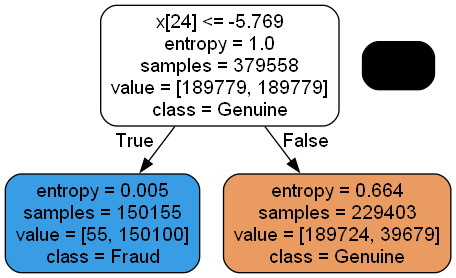

In [68]:
plot_decision_tree(final_model, target_classes = ['Genuine', 'Fraud'])

We can observe that based on a transformed variable x[24] and the threshold of -5.769. The model is classifying points into fraud if the value is lesser or equal to that otherwise they are being classified as genuine. The entropy of genuine leaf is quite high and this is expected I guess as many fraudulent trasnsaction can easily be genuine also, fraud trasnsactions doesn't always have to be significantly different from genuine ones.  
What is this x[24] though? Can we take a closer look?

##### Feature importance

In [80]:
final_pre_processor.steps

[('column_transformer',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('double_log_transform',
                                   FunctionTransformer(feature_names_out='one-to-one',
                                                       func=<function double_log_transform at 0x0000020D3FA916C0>),
                                   ['Amount']),
                                  ('cube_root_transformer',
                                   FunctionTransformer(feature_names_out='one-to-one',
                                                       func=<function cube_root_transform at 0x0000020D3FA931A0>),
                                   ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7',
                                    'V8', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16',
                                    'V17', 'V18', 'V19', 'V20', 'V21', 'V22',
                                    'V24', 'V25', 'V26', 'V27', 'V28']),
                                  ('drop_column

In [70]:
fitted_pca = final_pre_processor.steps[1][1]


In [79]:
fitted_pca.components_[24]

array([ 1.29817886e-02,  6.94346328e-02, -1.47660031e-01,  1.72070009e-01,
       -1.09473769e-01,  7.61255866e-02,  7.97721183e-02,  2.94637471e-01,
       -1.05212775e-02,  8.32022715e-02,  2.11913978e-01, -2.07920242e-01,
        3.16416662e-01,  2.99664177e-01,  3.34048473e-01,  4.28690894e-01,
        1.62898132e-01, -3.01339755e-02,  7.34720984e-03, -3.84549632e-01,
        2.50653814e-01,  2.47230312e-02, -2.18530974e-02, -2.13919488e-02,
        8.11782532e-02, -7.64874070e-02, -2.46610413e-07])

This should correspond to the x[24] feature that we saw in the decision tree and we can see the scaling coefficients of our predictor features which were used to linearly combine them to yield x[24]. If we had standard scaling before PCA then these coefficients would have directly meant that these coefficients highlight feature importances but the case is not so as whats going into the PCA are features which are on different scale. But we can somewhat compare V1 to V28 as they have similar scale but time and amount are on totally different scales. Maybe one option could be to add one standard scaler before PCA as well or we could just divide the coefficients by standard deviation of each variable after column transformation, then these scaled coefficients should correspond to feature importance.

In [82]:
fitted_transformer = final_pre_processor.steps[0][1]

In [87]:
feature_names = [string_obj.split("__")[-1] for string_obj in fitted_transformer.get_feature_names_out()]

In [90]:
x24_coefficients = fitted_pca.components_[24]

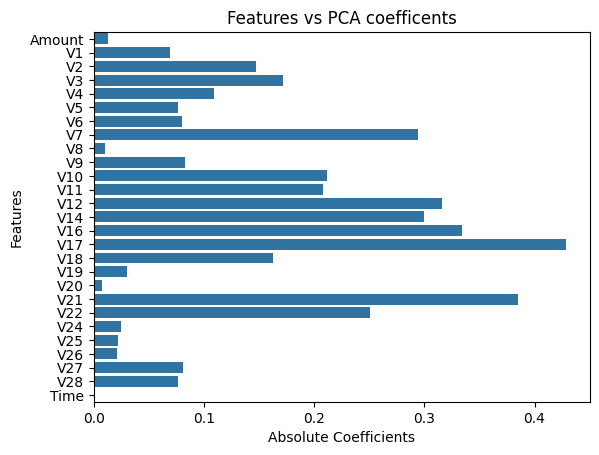

In [107]:
sns.barplot(x = np.abs(x24_coefficients), y = feature_names, orient = 'h')
plt.xlabel('Absolute Coefficients')
plt.ylabel('Features')
plt.title('Features vs PCA coefficents');

Lets try scaling these coefficients with the standard deviation of each variable.

In [104]:
X_std_after_transform = np.std(fitted_transformer.transform(X_train), axis = 0)

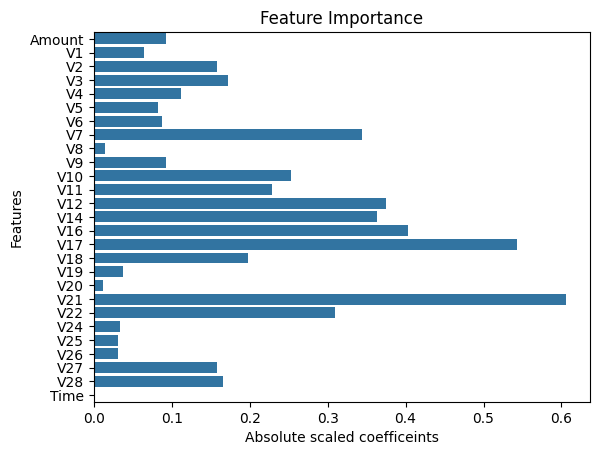

In [105]:
sns.barplot(x = np.abs(x24_coefficients/X_std_after_transform), y = feature_names, orient = 'h')
plt.xlabel('Absolute scaled coefficeints')
plt.ylabel('Features')
plt.title('Feature Importance');

Here, we can observe that V21 and V17 have the maximum effect on the obtained feature. While Time and V20 have the least importance.

##### Precision-Recall curve

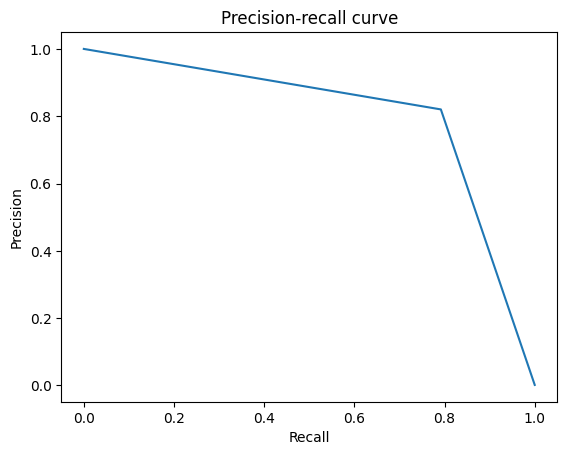

In [109]:
X_train_transformed = final_pre_processor.transform(X_train)
Y_train_pred = final_model.predict_proba(X_train_transformed)

precision, recall, _ = precision_recall_curve(Y_train, Y_train_pred[:, 1])

sns.lineplot(x = recall, y = precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall curve');

We can notice that there is a problem with decision tree as it cannot predict continuously varying probabilities in between 0 to 1. Based on our decision tree plot we can observe, it gives a fixed and same probability to each point when these are lying on the same side of decision boundary. It doesn't matter if the points are far or close to decision boundaries, the probaility assigned will be same. That's why such a model might not be appropriate if we want to fine tune precision-recall as per our need by adjusting probability threshold.

##### Comparison with a decision tree model without any feature engineering or selection

Lastly, I would like to compare how much the performance of the decision tree model has improved due to our feature engineering and feature selection initiatives.

I will just include SMOTE and standard scaler but no column transformation and PCA.

In [110]:
# Performing random search cross-validation

find_best_cv_params(X_train,
                    Y_train,
                    Pipeline([('standard_scaler', standard_scaler),
                              ('SMOTE_resample', SMOTE_resampler),
                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                    {'Decision_Tree__max_features': [None, 'sqrt', 'log2'],
                     'Decision_Tree__min_samples_leaf': list(range(40, 121, 5)),
                     'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                     'Decision_Tree__splitter': ['best', 'random'],
                     'Decision_Tree__criterion' :['gini', 'entropy', 'log_loss']}, 
                     area_under_precision_recall_curve_scorer,
                     'area under precision recall curve',
                     n_iter = 50)

For model - Decision_Tree random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.658
Validation set: 0.646
----------------------------------------------------------


{'Decision_Tree__splitter': 'best',
 'Decision_Tree__min_samples_leaf': 75,
 'Decision_Tree__max_features': None,
 'Decision_Tree__max_depth': 2,
 'Decision_Tree__criterion': 'entropy'}

In [111]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_train,
                                  Y_train,
                                  Pipeline([('standard_scaler', standard_scaler),
                                              ('SMOTE_resample', SMOTE_resampler),
                                              ('Decision_Tree', DecisionTreeClassifier(random_state = 123))]),                    
                                  {'Decision_Tree__max_features': [None],
                                   'Decision_Tree__min_samples_leaf': list(range(55, 96, 2)),
                                   'Decision_Tree__max_depth' : list(range(1, 3, 1)),
                                   'Decision_Tree__splitter': ['best'],
                                   'Decision_Tree__criterion' :['entropy']}, 
                                   area_under_precision_recall_curve_scorer,
                                   'area under precision recall curve',
                                   search_type = 'grid')

For model - Decision_Tree grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.652
Validation set: 0.646
----------------------------------------------------------
{'Decision_Tree__criterion': 'entropy', 'Decision_Tree__max_depth': 2, 'Decision_Tree__max_features': None, 'Decision_Tree__min_samples_leaf': 55, 'Decision_Tree__splitter': 'best'}


Comparing to Decision tree with SMOTE and PCA in experimentation section, the performance has increased by 24.45% due to the feature engineering(transformations and PCA) and feature selection.

### References

- https://www.kdnuggets.com/2023/01/7-smote-variations-oversampling.html
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#h-dealing-with-imbalanced-data
- https://scikit-learn.org/stable/
- https://www.youtube.com/@krishnaik06  
- Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron